In [48]:
import os, json, glob, subprocess, datetime as dt
import datetime
from pathlib import Path

import requests
import polars as pl
import pyarrow.dataset as ds
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import NullFormatter

import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
from scipy.stats import kstest, expon  # expon is Exp(1) if loc=0, scale=1

## Parquet data loading from the drive

In [49]:
# Paths on the EXTERNAL drive
PARQUET_DIR = Path("/media/vatereal/Main/parquet")
OUTPUT_DIR  = Path("/media/vatereal/Main/outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Polars display
pl.Config.set_tbl_rows(20)
pl.Config.set_fmt_str_lengths(80)

polars.config.Config

In [50]:
patterns = {
    "blocks": str(PARQUET_DIR / "blocks/day=*/blocks-*.parquet"),
    "txs":    str(PARQUET_DIR / "txs/day=*/txs-*.parquet"),
    "io":     str(PARQUET_DIR / "io/day=*/io-*.parquet"),
}
print({k: len(glob.glob(v)) for k,v in patterns.items()})

{'blocks': 6932, 'txs': 6932, 'io': 6932}


In [51]:
blocks_lf = pl.scan_parquet(patterns["blocks"], hive_partitioning=True, low_memory=True)
txs_lf    = pl.scan_parquet(patterns["txs"],    hive_partitioning=True, low_memory=True)
io_lf     = pl.scan_parquet(patterns["io"],     hive_partitioning=True, low_memory=True)

# Exploratory data analysis

In [52]:
# Quick peek helper
def peek(lf: pl.LazyFrame, n: int = 5):
    return lf.limit(n).collect(engine="streaming")

def show_info(name: str, lf: pl.LazyFrame, n: int = 5):
    schema_cols = lf.collect_schema().names()
    print(f"{name} cols:", schema_cols)
    print(peek(lf, n))
    print()

In [53]:
show_info("blocks", blocks_lf, n=5)

blocks cols: ['height', 'block_hash', 'time', 'tx_count', 'size', 'weight', 'day']
shape: (5, 7)
┌────────┬───────────────────────────┬─────────────────────┬──────────┬──────┬────────┬────────────┐
│ height ┆ block_hash                ┆ time                ┆ tx_count ┆ size ┆ weight ┆ day        │
│ ---    ┆ ---                       ┆ ---                 ┆ ---      ┆ ---  ┆ ---    ┆ ---        │
│ i64    ┆ str                       ┆ datetime[ns]        ┆ i64      ┆ i64  ┆ i64    ┆ date       │
╞════════╪═══════════════════════════╪═════════════════════╪══════════╪══════╪════════╪════════════╡
│ 0      ┆ 000000000019d6689c085ae16 ┆ 2009-01-03 18:15:05 ┆ 1        ┆ 285  ┆ 1140   ┆ 2009-01-03 │
│        ┆ 5831e934ff763ae46a2a6c172 ┆                     ┆          ┆      ┆        ┆            │
│        ┆ b3f1b60a8ce26f            ┆                     ┆          ┆      ┆        ┆            │
│ 1      ┆ 00000000839a8e6886ab5951d ┆ 2009-01-09 02:54:25 ┆ 1        ┆ 215  ┆ 860    ┆ 2009-01

In [54]:
show_info("txs",    txs_lf,    n=5)

txs cols: ['height', 'block_hash', 'time', 'txid', 'hash', 'size', 'vsize', 'weight', 'vin_count', 'vout_count', 'day']
shape: (5, 11)
┌────────┬────────────┬────────────┬────────────┬───┬────────┬───────────┬────────────┬────────────┐
│ height ┆ block_hash ┆ time       ┆ txid       ┆ … ┆ weight ┆ vin_count ┆ vout_count ┆ day        │
│ ---    ┆ ---        ┆ ---        ┆ ---        ┆   ┆ ---    ┆ ---       ┆ ---        ┆ ---        │
│ i64    ┆ str        ┆ datetime[n ┆ str        ┆   ┆ i64    ┆ i64       ┆ i64        ┆ date       │
│        ┆            ┆ s]         ┆            ┆   ┆        ┆           ┆            ┆            │
╞════════╪════════════╪════════════╪════════════╪═══╪════════╪═══════════╪════════════╪════════════╡
│ 0      ┆ 0000000000 ┆ 2009-01-03 ┆ 4a5e1e4baa ┆ … ┆ 816    ┆ 1         ┆ 1          ┆ 2009-01-03 │
│        ┆ 19d6689c08 ┆ 18:15:05   ┆ b89f3a3251 ┆   ┆        ┆           ┆            ┆            │
│        ┆ 5ae165831e ┆            ┆ 8a88c31bc8 ┆   ┆    

In [55]:
show_info("io",     io_lf,     n=5)

io cols: ['dir', 'height', 'time', 'txid', 'n', 'prev_txid', 'prev_vout', 'address', 'value', 'day']
shape: (5, 10)
┌─────┬────────┬──────────────┬─────────────────────┬───┬───────────┬─────────┬───────┬────────────┐
│ dir ┆ height ┆ time         ┆ txid                ┆ … ┆ prev_vout ┆ address ┆ value ┆ day        │
│ --- ┆ ---    ┆ ---          ┆ ---                 ┆   ┆ ---       ┆ ---     ┆ ---   ┆ ---        │
│ str ┆ i64    ┆ datetime[ns] ┆ str                 ┆   ┆ null      ┆ null    ┆ f64   ┆ date       │
╞═════╪════════╪══════════════╪═════════════════════╪═══╪═══════════╪═════════╪═══════╪════════════╡
│ in  ┆ 0      ┆ 2009-01-03   ┆ 4a5e1e4baab89f3a325 ┆ … ┆ null      ┆ null    ┆ null  ┆ 2009-01-03 │
│     ┆        ┆ 18:15:05     ┆ 18a88c31bc87f618f76 ┆   ┆           ┆         ┆       ┆            │
│     ┆        ┆              ┆ 673e2cc77ab2127b7af ┆   ┆           ┆         ┆       ┆            │
│     ┆        ┆              ┆ deda33b             ┆   ┆           ┆       

In [56]:
# Helpers: schema & quick counts

def show_schema(lf: pl.LazyFrame, name: str):
    schema = lf.collect_schema()
    print(f"\n## {name} schema")
    for col, dtype in schema.items():
        print(f"  {col}: {dtype}")

def quick_counts_sample(lf: pl.LazyFrame, name: str, n: int = 200_000, max_cols: int = 6):
    """
    sample first n rows but ONLY from "stable" columns
    (skip columns that are Null dtype in the global schema, because those
     are the ones that tend to explode at runtime like prev_vout)
    """
    sch = lf.collect_schema()
    stable_cols = [c for c, dt in sch.items() if dt != pl.Null][:max_cols]

    # pull only those columns, so Polars doesn't have to reconcile weird ones
    df = (
        lf.select([pl.col(c) for c in stable_cols])
        .limit(n)
        .collect()  # default engine="in-memory" is fine here
    )

    out = pl.DataFrame({
        "rows": [df.height],
        **{
            f"{c}__nulls": [df[c].null_count()]
            for c in stable_cols
        },
    })

    print(f"\n## {name} — SAMPLE rows & nulls (n={df.height})")


def has_columns(lf: pl.LazyFrame, *cols: str) -> bool:
    sch = lf.collect_schema()
    return all(c in sch for c in cols)

In [57]:
show_schema(blocks_lf, "blocks")
quick_counts_sample(blocks_lf, "blocks")


## blocks schema
  height: Int64
  block_hash: String
  time: Datetime(time_unit='ns', time_zone=None)
  tx_count: Int64
  size: Int64
  weight: Int64
  day: Date

## blocks — SAMPLE rows & nulls (n=200000)


In [58]:
show_schema(txs_lf, "txs")
quick_counts_sample(txs_lf, "txs")


## txs schema
  height: Int64
  block_hash: String
  time: Datetime(time_unit='ns', time_zone=None)
  txid: String
  hash: String
  size: Int64
  vsize: Int64
  weight: Int64
  vin_count: Int64
  vout_count: Int64
  day: Date

## txs — SAMPLE rows & nulls (n=200000)


In [59]:
show_schema(io_lf, "io")
quick_counts_sample(io_lf, "io")


## io schema
  dir: String
  height: Int64
  time: Datetime(time_unit='ns', time_zone=None)
  txid: String
  n: Int64
  prev_txid: Null
  prev_vout: Null
  address: Null
  value: Float64
  day: Date

## io — SAMPLE rows & nulls (n=200000)


In [60]:
# ---------- helpers ----------
def colnames(lf: pl.LazyFrame) -> list[str]:
    return list(lf.collect_schema().names())

def first_col(cols, candidates):
    s = set(cols)
    for c in candidates:
        if c in s:
            return c
    return None

def day_expr(lf: pl.LazyFrame, colname: str) -> pl.Expr:
    """
    Return an Expr producing a pl.Date 'day' from whatever timestamp-like column.
    - Datetime/Date -> truncate to day
    - Int epoch -> auto-handle sec vs ms
    - Utf8 -> try parse to Datetime then truncate
    Always returns pl.Date.
    """
    dtype = lf.collect_schema().get(colname)
    c = pl.col(colname)

    if dtype == pl.Date:
        return c.cast(pl.Date)

    if dtype == pl.Datetime:
        return c.dt.truncate("1d").cast(pl.Date)

    if dtype in (pl.Int64, pl.Int32, pl.UInt64, pl.UInt32):
        # Heuristic: >1e11 → looks like milliseconds, else seconds
        secs = pl.when(c > 100_000_000_000) \
                 .then((c / 1000).cast(pl.Int64)) \
                 .otherwise(c.cast(pl.Int64))
        return pl.from_epoch(secs, unit="s").dt.truncate("1d").cast(pl.Date)

    if dtype == pl.Utf8:
        return (
            c.str.strptime(pl.Datetime, strict=False)
             .dt.truncate("1d")
             .cast(pl.Date)
        )

    # Fallback: try cast to Datetime
    return (
        c.cast(pl.Datetime, strict=False)
         .dt.truncate("1d")
         .cast(pl.Date)
    )

In [61]:
def lineplot(df: pl.DataFrame, x, y, title, logy=False):
    # convert Polars -> pandas
    pd_df = df.to_pandas()

    # Try to make x a datetime
    try:
        pd_df[x] = pd.to_datetime(pd_df[x], errors="raise")
        is_date_axis = True
    except Exception:
        is_date_axis = False

    fig, ax = plt.subplots(figsize=(10,4))

    ax.plot(pd_df[x], pd_df[y])
    ax.set_title(title)
    ax.set_xlabel(str(x))
    ax.set_ylabel(str(y))

    # log y only if strictly positive
    if logy and (pd_df[y] > 0).all():
        ax.set_yscale("log")

    if is_date_axis:
        # --- Major ticks: yearly, label = "2014", "2015", ...
        year_locator = mdates.YearLocator(base=1)
        year_fmt     = mdates.DateFormatter('%Y')
        ax.xaxis.set_major_locator(year_locator)
        ax.xaxis.set_major_formatter(year_fmt)

        # --- Minor ticks: quarters (Jan/Apr/Jul/Oct), no labels
        quarter_locator = mdates.MonthLocator(bymonth=[1,4,7,10])
        ax.xaxis.set_minor_locator(quarter_locator)
        ax.xaxis.set_minor_formatter(NullFormatter())

        # --- Styling ticks ---
        # Major ticks: black labels, horizontal
        ax.tick_params(
            axis='x',
            which='major',
            length=6,
            color='black',
            labelrotation=0,
            labelsize=8,
        )

        # Minor ticks: short red tick marks, no text
        ax.tick_params(
            axis='x',
            which='minor',
            length=4,
            color='red',
            labelbottom=False  # don't show text for minor ticks
        )

        # center-align the year labels
        for lab in ax.get_xticklabels(which='major'):
            lab.set_ha('center')

        # ensure full range is visible without clipping
        ax.set_xlim(pd_df[x].min(), pd_df[x].max())

    fig.tight_layout()
    plt.show()


In [62]:
def barplot(df: pl.DataFrame, x, y, title):
    plt.figure(figsize=(8,4))
    pd = df.to_pandas()
    plt.bar(pd[x], pd[y])
    plt.title(title)
    plt.xlabel(str(x)); plt.ylabel(str(y))
    plt.tight_layout(); plt.show()

def histplot(series: pl.Series, bins=50, title="Histogram", logx=False, logy=False):
    plt.figure(figsize=(8,4))
    x = series.drop_nulls().to_numpy()
    if logx:
        import numpy as np
        x = x[x>0]
        x = np.log10(x)
    plt.hist(x, bins=bins)
    plt.title(title)
    if logx: plt.xlabel("log10(value)")
    else:    plt.xlabel("value")
    if logy: plt.yscale("log")
    plt.tight_layout(); plt.show()

# 0) Daily blocks & 7d MA

blocks_daily tail:
shape: (5, 2)
┌────────────┬────────┐
│ day        ┆ blocks │
│ ---        ┆ ---    │
│ date       ┆ u32    │
╞════════════╪════════╡
│ 2018-07-08 ┆ 158    │
│ 2018-07-09 ┆ 136    │
│ 2018-07-10 ┆ 149    │
│ 2018-07-11 ┆ 135    │
│ 2018-07-12 ┆ 100    │
└────────────┴────────┘


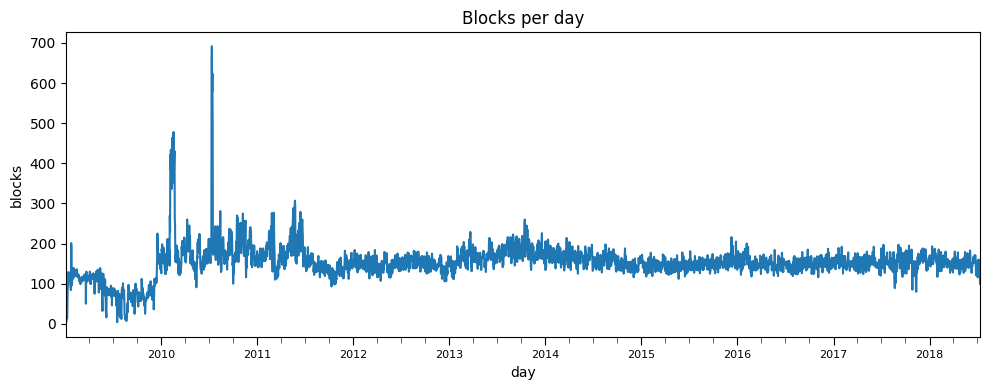

In [ ]:
# ---------- DAILY BLOCKS + 7d MA ----------

blk_schema = blocks_lf.collect_schema()
blk_cols   = list(blk_schema.keys())

blk_time_col = first_col(
    blk_cols,
    ["day", "block_time", "time", "timestamp", "ts", "datetime"]
)
if blk_time_col is None:
    raise RuntimeError("No usable timestamp/day column in blocks_lf")

if blk_time_col == "day":
    blocks_daily = (
        blocks_lf
        .select(pl.col("day").cast(pl.Date).alias("day"))
        .group_by("day")
        .agg(pl.len().alias("blocks"))
        .sort("day")
        .collect(engine="streaming")
    )
else:
    blocks_daily = (
        blocks_lf
        .select(day_expr(blocks_lf, blk_time_col).cast(pl.Date).alias("day"))
        .group_by("day")
        .agg(pl.len().alias("blocks"))
        .sort("day")
        .collect(engine="streaming")
    )

# 7-day moving average
blocks_daily = blocks_daily.with_columns(
    pl.col("blocks").rolling_mean(window_size=7).alias("blocks_ma7")
)

print("blocks_daily tail:")
print(blocks_daily.tail(5))

# ---------- PLOTS ----------
lineplot(blocks_daily, x="day", y="blocks",     title="Blocks per day",               logy=False)
lineplot(blocks_daily, x="day", y="blocks_ma7", title="Blocks per day (7-day MA)",    logy=False)

## 1) Daily transactions & 7d MA

Daily tx (tail):
shape: (5, 3)
┌────────────┬──────────┬───────────────┐
│ day        ┆ tx_count ┆ tx_count_ma7  │
│ ---        ┆ ---      ┆ ---           │
│ str        ┆ u32      ┆ f64           │
╞════════════╪══════════╪═══════════════╡
│ 2018-07-08 ┆ 155685   ┆ 192752.428571 │
│ 2018-07-09 ┆ 206546   ┆ 193788.428571 │
│ 2018-07-10 ┆ 216063   ┆ 193690.714286 │
│ 2018-07-11 ┆ 202603   ┆ 193092.857143 │
│ 2018-07-12 ┆ 147590   ┆ 185662.857143 │
└────────────┴──────────┴───────────────┘


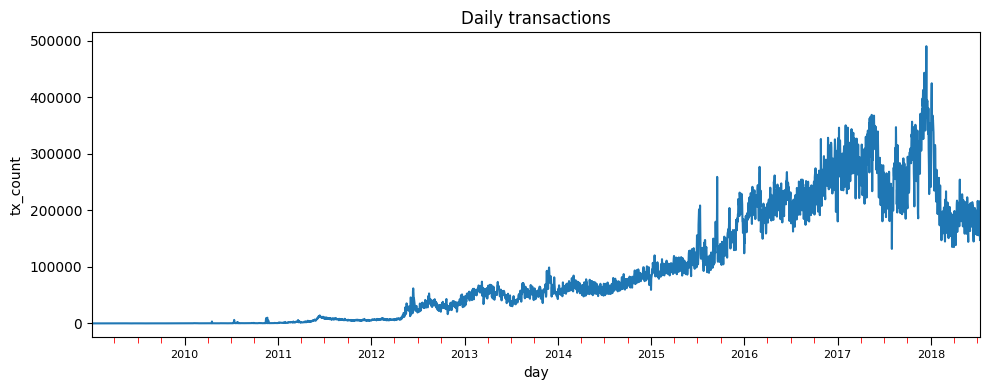

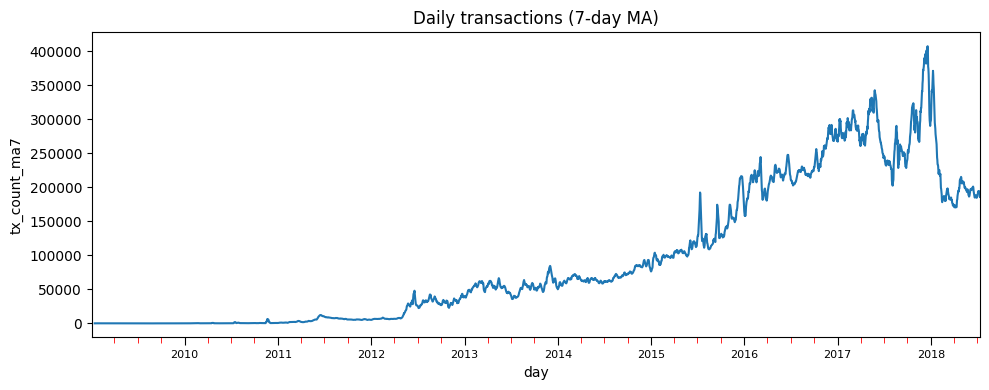

In [64]:
tx_schema   = txs_lf.collect_schema()
blk_schema  = blocks_lf.collect_schema()
tx_cols     = list(tx_schema.keys())
blk_cols    = list(blk_schema.keys())

# Prefer tx-level count (more direct than summing n_tx)
tx_time_col = first_col(tx_cols, ["tx_time","block_time","time","timestamp","ts","datetime","day"])

if tx_time_col:
    # We can compute daily tx count directly from txs_lf

    # If hive partitioning already gave us a 'day' column, use that (cheapest).
    if "day" in tx_cols:
        day_col_expr = pl.col("day").cast(pl.Utf8)
        day_col_name = "day"
    else:
        # build a proper day column from tx_time_col
        day_col_expr = day_expr(txs_lf, tx_time_col)
        day_col_name = "day"

    # Build a trimmed lazyframe with only what we truly need:
    # - timestamp or 'day'
    needed_cols = []
    if "day" in tx_cols:
        needed_cols.append("day")
    else:
        needed_cols.append(tx_time_col)

    needed_cols = list(dict.fromkeys([c for c in needed_cols if c is not None]))

    tx_small = txs_lf.select(needed_cols)

    # Streamable daily aggregation:
    daily_base = (
        tx_small
        .with_columns([
            day_col_expr.alias("day"),
        ])
        .group_by("day")
        .agg(
            pl.len().alias("tx_count")   # number of tx rows that day
        )
        .sort("day")
        .collect(engine="streaming")         # <-- critical: streaming
    )

else:
    # Fallback: count txs per block, then sum per day from blocks_lf

    n_tx_col     = first_col(blk_cols, ["n_tx","tx_count","txs"])
    blk_time_col = first_col(blk_cols, ["block_time","time","timestamp","ts","datetime","day"])

    # same "day" trick: if hive already gave 'day', use it
    if "day" in blk_cols:
        day_col_expr = pl.col("day").cast(pl.Utf8)
        day_col_name = "day"
    else:
        day_col_expr = day_expr(blocks_lf, blk_time_col)
        day_col_name = "day"

    # we only actually need [blk_time_col or 'day', n_tx_col]
    needed_cols = []
    needed_cols.append(n_tx_col)
    if "day" in blk_cols:
        needed_cols.append("day")
    else:
        needed_cols.append(blk_time_col)

    needed_cols = list(dict.fromkeys([c for c in needed_cols if c is not None]))

    blk_small = blocks_lf.select(needed_cols)

    daily_base = (
        blk_small
        .with_columns([
            day_col_expr.alias("day"),
        ])
        .group_by("day")
        .agg(
            pl.col(n_tx_col).sum().alias("tx_count")
        )
        .sort("day")
        .collect(engine="streaming")
    )

# At this point daily_base is tiny: one row per day.
daily_tx = daily_base.with_columns(
    pl.col("tx_count")
    .rolling_mean(window_size=7)
    .alias("tx_count_ma7")
)

print("Daily tx (tail):")
print(daily_tx.tail(5))

lineplot(daily_tx, "day", "tx_count",        "Daily transactions")
lineplot(daily_tx, "day", "tx_count_ma7",    "Daily transactions (7-day MA)")

## 2) Daily output volume in BTC & 7 day MA

Daily volume (tail):
shape: (5, 3)
┌────────────┬─────────────┬────────────────┐
│ day        ┆ volume_btc  ┆ volume_btc_ma7 │
│ ---        ┆ ---         ┆ ---            │
│ str        ┆ f32         ┆ f32            │
╞════════════╪═════════════╪════════════════╡
│ 2018-07-08 ┆ 751026.5625 ┆ 901851.5625    │
│ 2018-07-09 ┆ 1.0487e6    ┆ 909097.4375    │
│ 2018-07-10 ┆ 1.1740e6    ┆ 925007.125     │
│ 2018-07-11 ┆ 844513.5625 ┆ 918520.625     │
│ 2018-07-12 ┆ 684603.0    ┆ 868820.8125    │
└────────────┴─────────────┴────────────────┘


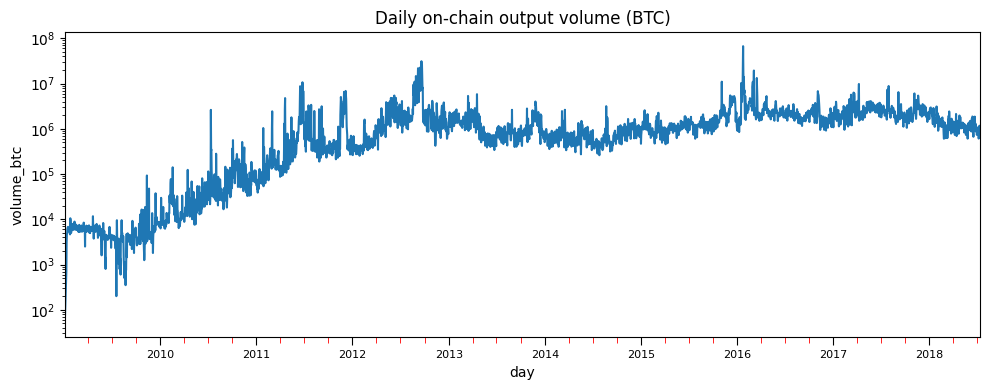

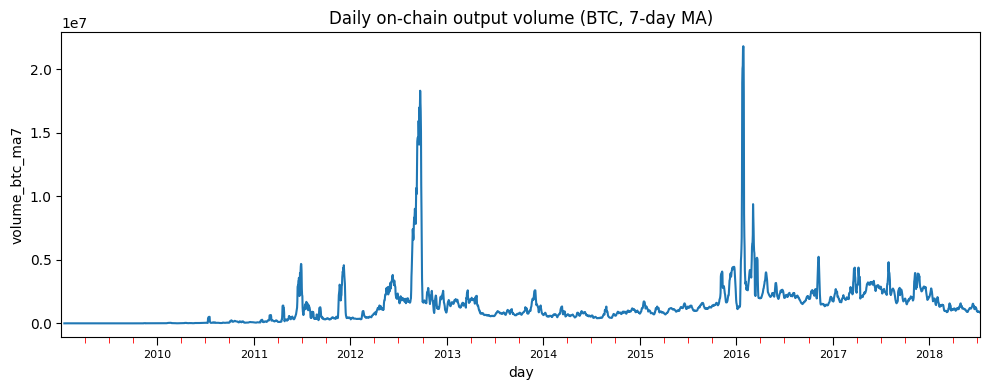

In [65]:
schema   = io_lf.collect_schema()
io_cols  = list(schema.keys())

# value expression (BTC float column)
val_expr = None
val_src  = None  # name of the column we'll keep

btc_names  = ["value_btc","amount_btc","btc","out_value_btc","output_btc"]
sats_names = ["value_sats","satoshis","sats","out_value_sats","amount_sats","vout_sats"]
gen_names  = ["value","amount","vout_value","output_value","v"]

for nm in btc_names:
    if nm in io_cols:
        val_expr = pl.col(nm).cast(pl.Float32)  # downcast early
        val_src = nm
        break

if val_expr is None:
    for nm in sats_names:
        if nm in io_cols:
            # sats -> BTC, also downcast
            val_expr = (pl.col(nm) / 1e8).cast(pl.Float32)
            val_src = nm
            break

if val_expr is None:
    gen = first_col(io_cols, gen_names)
    if gen:
        dtp = schema.get(gen)
        if dtp is not None and dtp.is_integer():
            val_expr = (pl.col(gen) / 1e8).cast(pl.Float32)
        else:
            val_expr = pl.col(gen).cast(pl.Float32)
        val_src = gen

# pick output flag column
side_col = None
out_mask_expr = pl.lit(True)
if "is_output" in io_cols:
    out_mask_expr = pl.col("is_output")
    side_col = "is_output"
elif "is_input" in io_cols:
    out_mask_expr = ~pl.col("is_input")
    side_col = "is_input"
else:
    cand = first_col(io_cols, ["io_type","direction","side","inout","kind","role","io"])
    if cand:
        # build a boolean "is_out" from a string contains
        side_col = cand
        out_mask_expr = (
            pl.col(cand)
            .cast(pl.Utf8)
            .str.contains("out", literal=True)
        )

# pick a day/timestamp column
# Prefer hive 'day' if present (cheapest)
if "day" in io_cols:
    day_col = "day"
    day_expr_final = pl.col("day").cast(pl.Utf8)
else:
    ts_col = first_col(io_cols, ["block_time","tx_time","time","timestamp","ts","datetime","day"])
    day_col = "day"  # we'll create it
    day_expr_final = day_expr(io_lf, ts_col)  # will truncate to 1d

# Build a minimal lazyframe with ONLY needed columns
needed_cols = []

if val_src is not None:
    needed_cols.append(val_src)

if side_col is not None:
    needed_cols.append(side_col)

# If we have a timestamp col separate from 'day', include it
if "day" in io_cols:
    needed_cols.append("day")
else:
    needed_cols.append(ts_col)

# Deduplicate / drop None
needed_cols = [c for c in dict.fromkeys(needed_cols) if c is not None]

io_small = io_lf.select(needed_cols)

# Streamable daily aggregation:
daily_base = (
    io_small
    .with_columns([
        day_expr_final.alias("day"),
        val_expr.alias("value_btc"),
        out_mask_expr.alias("is_out"),
    ])
    .filter(pl.col("is_out"))
    .group_by("day")
    .agg(
        pl.col("value_btc").sum().alias("volume_btc")
    )
    .sort("day")
    .collect(engine="streaming")
)

# Now daily_base is small (one row per day). We can finish in-memory.
daily_vol = daily_base.with_columns(
    pl.col("volume_btc")
    .rolling_mean(window_size=7)
    .alias("volume_btc_ma7")
)

print("Daily volume (tail):")
print(daily_vol.tail(5))

lineplot(daily_vol, "day", "volume_btc",     "Daily on-chain output volume (BTC)", logy=True)
lineplot(daily_vol, "day", "volume_btc_ma7", "Daily on-chain output volume (BTC, 7-day MA)", logy=True)

## 3) Inter-block time histogram

#### Homogeneous Poisson process

Inter-block intervals: n=531385
Mean inter-block time: 563.47 s  →  λ_hat = 0.001775 1/s


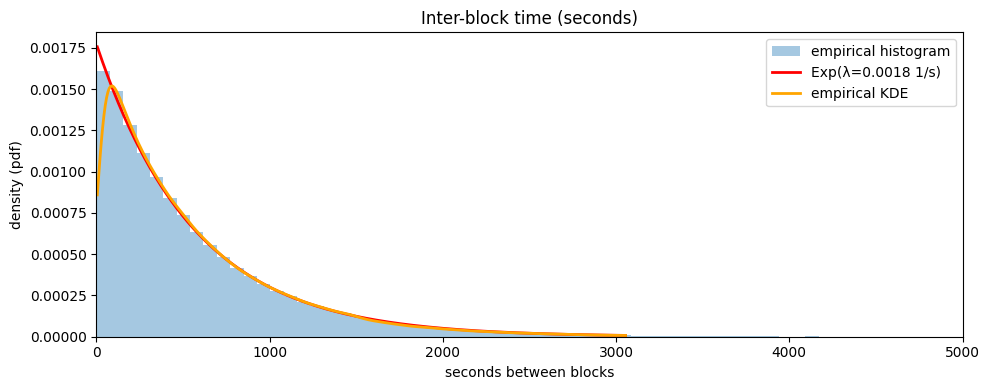

In [66]:
blk_schema  = blocks_lf.collect_schema()
blk_cols    = list(blk_schema.keys())

blk_time_col = first_col(blk_cols, ["block_time","time","timestamp","ts","datetime"])

if blk_time_col:
    dt = blk_schema.get(blk_time_col)
    col = pl.col(blk_time_col)

    # Build an expression "ts_s_expr" that is *seconds since epoch* (Int64)
    if dt == pl.Datetime:
        # already a Datetime -> convert to epoch seconds
        ts_s_expr = col.dt.epoch(time_unit="s").cast(pl.Int64)

    elif dt in (pl.Int64, pl.Int32, pl.UInt64, pl.UInt32):
        # numeric -> could be sec or ms
        # heuristic: if value > 1e11, assume ms and divide by 1000
        unix_s = (
            pl.when(col > 100_000_000_000)
            .then((col / 1000).cast(pl.Int64))
            .otherwise(col.cast(pl.Int64))
        )
        ts_s_expr = unix_s

    elif dt == pl.Date:
        # only day precision -> can't compute sub-day spacings reliably
        print("Block time has only day precision; skipping inter-block histogram.")
        ts_s_expr = None

    else:
        # fallback: cast to Datetime, then epoch seconds
        ts_s_expr = (
            col.cast(pl.Datetime, strict=False)
               .dt.epoch(time_unit="s")
               .cast(pl.Int64)
        )

    if ts_s_expr is not None:
        # 1) Take just the timestamp column (keeps memory light)
        blk_small = blocks_lf.select(ts_s_expr.alias("ts_s"))

        # 2) Sort globally by timestamp, diff consecutive blocks, filter nonsense
        deltas_df = (
            blk_small
            .sort("ts_s")
            .with_columns(
                pl.col("ts_s").diff().alias("delta_s")  # seconds between blocks
            )
            .select("delta_s")
            .filter(
                pl.col("delta_s").is_not_null()
                & (pl.col("delta_s") > 0)
                & (pl.col("delta_s") < 36_000)  # drop >10h gaps / timestamp lies / import junk
            )
            .collect()  # can't stream because of global sort, but it's now 1 tiny column
        )

        block_intervals_s = deltas_df.get_column("delta_s").cast(pl.Float32)
        n_intervals = len(block_intervals_s)
        print(f"Inter-block intervals: n={n_intervals}")

        if n_intervals > 0:
            # --- numpy array of intervals in seconds ---
            x = block_intervals_s.to_numpy()

            # === Poisson-process model: Exponential fit ===
            # MLE for Exp(lambda) is lambda_hat = 1 / mean(x)
            mean_interval = float(np.mean(x))
            lam_hat = 1.0 / mean_interval if mean_interval > 0 else 0.0
            print(
                f"Mean inter-block time: {mean_interval:.2f} s  "
                f"→  λ_hat = {lam_hat:.6f} 1/s"
            )

            # Smooth x-grid for curves.
            # We'll focus curves on the central 0.5%..99.5% range so they don't get
            # yanked around by multi-hour outliers.
            xs = np.linspace(
                np.percentile(x, 0.5),
                np.percentile(x, 99.5),
                400
            )

            # exponential pdf: f(t) = λ e^{-λ t}
            if lam_hat > 0:
                exp_pdf = lam_hat * np.exp(-lam_hat * xs)
            else:
                exp_pdf = np.zeros_like(xs)

            # === empirical KDE ===
            # (if scipy isn't installed, we'll just skip the KDE curve gracefully)
            kde_y = None
            try:
                from scipy.stats import gaussian_kde
                kde = gaussian_kde(x)
                kde_y = kde(xs)
            except Exception as e:
                print("Skipping KDE overlay (scipy not available?):", e)

            # === plot ===
            fig, ax = plt.subplots(figsize=(10,4))

            # Histogram of actual inter-block times (full range, including tail!)
            ax.hist(
                x,
                bins=400,
                density=True,            # so area ~1, comparable to pdf/kde
                alpha=0.4,
                edgecolor="none",
                label="empirical histogram"
            )

            # Overlay red exponential fit
            ax.plot(
                xs,
                exp_pdf,
                color="red",
                linewidth=2,
                label=f"Exp(λ={lam_hat:.4f} 1/s)"
            )

            if kde_y is not None:
                ax.plot(
                    xs,
                    kde_y,
                    color="orange",
                    linewidth=2,
                    label="empirical KDE"
                )

            ax.set_title("Inter-block time (seconds)")
            ax.set_xlabel("seconds between blocks")
            ax.set_ylabel("density (pdf)")
            ax.legend()
            ax.set_xlim(0, 5000)

            fig.tight_layout()
            plt.show()

        else:
            print("No intervals survived the filters; check timestamp units or block_time source.")
else:
    print("No block timestamp found; skipping inter-block histogram.")

In [67]:
# x: numpy array of inter-block times in seconds
# lam_hat: fitted rate (1 / mean(x))

def exp_cdf(t, lam):
    # vectorized CDF of Exp(lam) for t >= 0
    t = np.asarray(t)
    return 1.0 - np.exp(-lam * t)

ks_stat, p_value = kstest(x, lambda t: exp_cdf(t, lam_hat))

print("Kolmogorov–Smirnov test vs Exp(λ̂):")
print(f"  ks_stat = {ks_stat:.6f}")
print(f"  p_value = {p_value:.6g}")

if p_value < 0.05:
    print("  -> Reject H0 at 5%: data does NOT look like pure Exp(λ̂).")
else:
    print("  -> Cannot reject H0 at 5%: data is statistically compatible with Exp(λ̂).")

Kolmogorov–Smirnov test vs Exp(λ̂):
  ks_stat = 0.009565
  p_value = 1.17622e-42
  -> Reject H0 at 5%: data does NOT look like pure Exp(λ̂).


#### Non homogeneous Poisson process

In [68]:
# === Step 0: pick timestamp column and convert to epoch seconds ===

blk_schema  = blocks_lf.collect_schema()
blk_cols    = list(blk_schema.keys())

blk_time_col   = first_col(blk_cols, ["block_time","time","timestamp","ts","datetime"])
blk_height_col = first_col(blk_cols, ["height","block_height","number","idx","block_number"])

if blk_time_col is None or blk_height_col is None:
    raise RuntimeError("Need both block height and block timestamp columns for NHPP test.")

dt = blk_schema.get(blk_time_col)
col_ts = pl.col(blk_time_col)

# normalize timestamp to 'ts_s' = seconds since epoch (Int64)
if dt == pl.Datetime:
    ts_s_expr = col_ts.dt.epoch(time_unit="s").cast(pl.Int64)
elif dt in (pl.Int64, pl.Int32, pl.UInt64, pl.UInt32):
    # heuristic for ms vs sec
    ts_s_expr = (
        pl.when(col_ts > 100_000_000_000)        # > 1e11 ~ definitely ms
        .then((col_ts / 1000).cast(pl.Int64))
        .otherwise(col_ts.cast(pl.Int64))
    )
elif dt == pl.Date:
    raise RuntimeError("Only day precision in timestamps; can't do NHPP timing test.")
else:
    ts_s_expr = (
        col_ts.cast(pl.Datetime, strict=False)
              .dt.epoch(time_unit="s")
              .cast(pl.Int64)
    )

# === Step 1: build height + timestamp, sort by height, diff timestamps ===
# We do NOT filter out long gaps here: we keep outliers, per your request.

deltas_full_df = (
    blocks_lf
    .select([
        pl.col(blk_height_col).cast(pl.Int64).alias("height"),
        ts_s_expr.alias("ts_s"),
    ])
    .sort("height")
    .with_columns([
        pl.col("ts_s").diff().alias("delta_s"),        # inter-block time in seconds
    ])
    .filter(
        pl.col("delta_s").is_not_null()
        & (pl.col("delta_s") > 0)                      # drop zero/negative (weird timestamp reversals)
    )
    .with_columns([
        # difficulty epoch index (0,1,2,...) = floor(height/2016)
        (pl.col("height") // 2016).alias("epoch_idx")
    ])
    .collect()
)

# Now we have:
#   height, ts_s, delta_s, epoch_idx
# and delta_s includes long-tail gaps. Good.

# === Step 2: estimate lambda per epoch ===
epoch_stats = (
    deltas_full_df
    .group_by("epoch_idx")
    .agg([
        pl.col("delta_s").mean().alias("mean_delta_s"),
        pl.len().alias("n_blocks_epoch"),
    ])
    .with_columns([
        (1.0 / pl.col("mean_delta_s")).alias("lambda_epoch"),  # blocks per second in that epoch
    ])
)

# === Step 3: join epoch lambdas back onto each block interval ===
deltas_with_lambda = (
    deltas_full_df
    .join(epoch_stats.select(["epoch_idx","lambda_epoch"]), on="epoch_idx", how="left")
    .with_columns([
        # τ_i = λ_epoch * Δt_i
        (pl.col("lambda_epoch") * pl.col("delta_s")).alias("tau_rescaled"),
    ])
    # we only keep rows where we could compute lambda_epoch
    .filter(pl.col("tau_rescaled").is_not_null() & (pl.col("tau_rescaled") > 0))
)

# pull numpy arrays
tau = deltas_with_lambda["tau_rescaled"].to_numpy()
lambda_epochs = deltas_with_lambda["lambda_epoch"].to_numpy()
print(f"Rescaled gaps count (tau samples): {len(tau)}")

# === Step 4: KS test against Exp(1)
# Under NHPP with piecewise-constant λ per epoch, the tau_rescaled
# should be i.i.d. Exp(1), i.e. exponential with mean=1.
#
# SciPy's expon (default) is Exp(scale=1, loc=0) -> mean 1, rate 1.

ks_stat, p_value = kstest(tau, expon.cdf)  # compares against Exp(1)

print("Kolmogorov–Smirnov test vs piecewise-constant NHPP (Exp(1) after rescaling):")
print(f"  ks_stat = {ks_stat:.6f}")
print(f"  p_value = {p_value:.6g}")
if p_value < 0.05:
    print("  -> Reject H0 at 5%: even the piecewise-constant NHPP shows detectable deviations.")
else:
    print("  -> Cannot reject H0 at 5%: consistent with Poisson-with-changing-rate-per-epoch.")

# === Optional sanity info ===
global_mean_interval = float(deltas_full_df["delta_s"].mean())
global_lambda = 1.0 / global_mean_interval
print(f"Global mean interval: {global_mean_interval:.2f} s  (λ_global ~ {global_lambda:.6f} 1/s)")

print(
    epoch_stats
    .select([
        "epoch_idx",
        "n_blocks_epoch",
        "mean_delta_s",
        "lambda_epoch"
    ])
    .head(5)
)

Rescaled gaps count (tau samples): 517638
Kolmogorov–Smirnov test vs piecewise-constant NHPP (Exp(1) after rescaling):
  ks_stat = 0.022291
  p_value = 7.1199e-224
  -> Reject H0 at 5%: even the piecewise-constant NHPP shows detectable deviations.
Global mean interval: 586.65 s  (λ_global ~ 0.001705 1/s)
shape: (5, 4)
┌───────────┬────────────────┬──────────────┬──────────────┐
│ epoch_idx ┆ n_blocks_epoch ┆ mean_delta_s ┆ lambda_epoch │
│ ---       ┆ ---            ┆ ---          ┆ ---          │
│ i64       ┆ u32            ┆ f64          ┆ f64          │
╞═══════════╪════════════════╪══════════════╪══════════════╡
│ 3         ┆ 2001           ┆ 774.483258   ┆ 0.001291     │
│ 0         ┆ 2015           ┆ 1020.094789  ┆ 0.00098      │
│ 18        ┆ 1996           ┆ 450.632766   ┆ 0.002219     │
│ 134       ┆ 1925           ┆ 552.128831   ┆ 0.001811     │
│ 143       ┆ 1858           ┆ 602.400431   ┆ 0.00166      │
└───────────┴────────────────┴──────────────┴──────────────┘


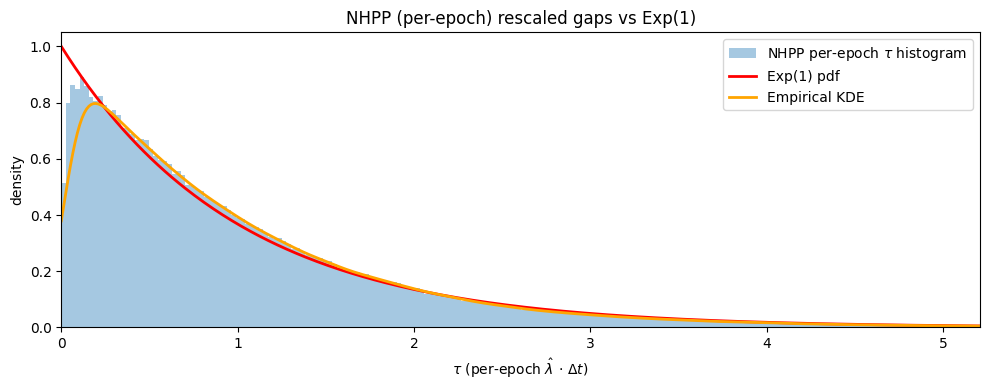

In [69]:
# === Step 5: Visualize NHPP (per-epoch rescaled) gaps vs Exp(1) ===

# choose a sane max for visualization (e.g., 99.5% of mass)
if len(tau) == 0:
    raise RuntimeError("No rescaled gaps (tau) available to plot.")
xmax = np.percentile(tau, 99.5)

fig, ax = plt.subplots(figsize=(10, 4))

# Dense histogram of tau with many bins
ax.hist(
    tau,
    bins=200,
    range=(0, xmax),
    density=True,
    alpha=0.4,
    edgecolor="none",
    label=r"NHPP per-epoch $\tau$ histogram"
)

# Overlay the Exp(1) pdf
xs = np.linspace(0, xmax, 400)
exp1_pdf = np.exp(-xs)  # Exp(1) pdf: f(t)=e^{-t}, t>=0
ax.plot(xs, exp1_pdf, color="red", linewidth=2, label=r"Exp(1) pdf")


kde = gaussian_kde(tau)
kde_y = kde(xs)
ax.plot(xs, kde_y, color="orange", linewidth=2, label="Empirical KDE")

ax.set_xlim(0, xmax)
ax.set_xlabel(r"$\tau$ (per-epoch $\hat{\lambda}\,\cdot\,\Delta t$)")
ax.set_ylabel("density")
ax.set_title("NHPP (per-epoch) rescaled gaps vs Exp(1)")
ax.legend()
plt.tight_layout()
plt.show()


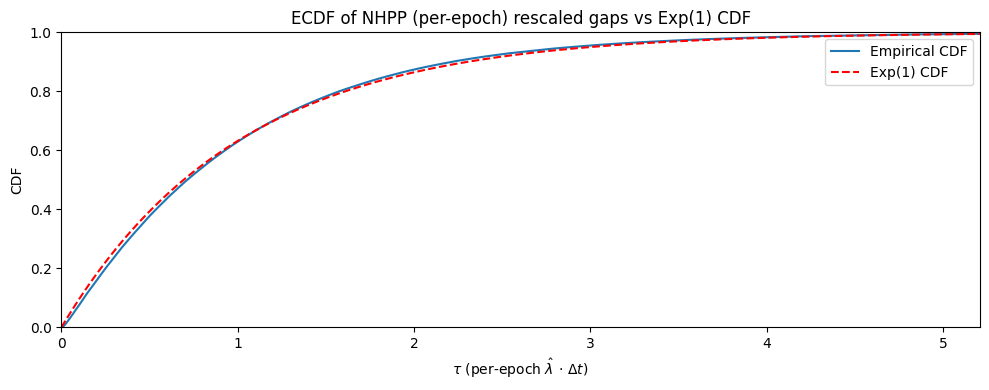

In [70]:
# === ECDF vs Exp(1) CDF ===
tau_sorted = np.sort(tau)
emp_cdf = np.arange(1, len(tau_sorted) + 1) / len(tau_sorted)
theo_cdf = 1.0 - np.exp(-tau_sorted)  # Exp(1) CDF

xmax = np.percentile(tau_sorted, 99.5)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(tau_sorted, emp_cdf, label="Empirical CDF")
ax.plot(tau_sorted, theo_cdf, linestyle="--", label=r"Exp(1) CDF", color="red")

ax.set_xlim(0, xmax)
ax.set_ylim(0, 1)
ax.set_xlabel(r"$\tau$ (per-epoch $\hat{\lambda}\,\cdot\,\Delta t$)")
ax.set_ylabel("CDF")
ax.set_title("ECDF of NHPP (per-epoch) rescaled gaps vs Exp(1) CDF")
ax.legend()
plt.tight_layout()
plt.show()

## Step-by-step model

### 1. Sort chain by height

We take `(height, timestamp)` pairs and sort by `height` in strictly increasing order.  
This gives us the canonical main-chain ordering of blocks.

From that sequence, we compute the inter-block intervals:

$\Delta t_i = t_i - t_{i-1}$

where:
- $t_i$ is the timestamp (in seconds since epoch) of block with height $i$,
- $\Delta t_i$ is the observed waiting time between block $i-1$ and block $i$.


---

### 2. Estimate a local block rate $\hat{\lambda}_i$

Instead of assuming one global rate $\lambda$, or one rate per 2016-block difficulty epoch, we estimate a **local instantaneous rate** for each block using a trailing sliding window of the last $W$ blocks.

For each block $i$, we:
1. Look back at the previous $W$ inter-block gaps $\Delta t_{i-W}, \ldots, \Delta t_{i-1}$.
2. Take their mean (average wait time in seconds).
3. Invert that mean to get a rate in blocks per second.

Formally:

$\hat{\lambda}_i
= \left(
\frac{1}{W}
\sum_{k=i-W}^{i-1} \Delta t_k
\right)^{-1}$

Interpretation:
- $\hat{\lambda}_i$ says “how fast were blocks arriving recently?”  
- This is essentially “realized hashrate / difficulty” over the last $\sim W$ blocks.

Why choose $W \approx 50$?
- $\sim 50$ Bitcoin blocks $\approx$ $\sim$8 hours (assuming $\sim$10 min/block).
- That’s short enough to capture sub-epoch hashrate shocks:
  - miners turning machines off/on,
  - power curtailment,
  - pool-level behavior changes.
- That’s long enough to smooth over some timestamp noise.

Tuning $W$:
- Smaller $W$ (e.g. 10) $\rightarrow$ very reactive but noisy.
- Larger $W$ (e.g. 200) $\rightarrow$ smoother, starts behaving like a per-epoch average again.


---

### 3. Locally rescale each observed gap

Now we define the **rescaled waiting time** $\tau_i$:

$\tau_i
= \hat{\lambda}_i \cdot \Delta t_i$

Intuition:
- If the current effective block-finding rate is $\hat{\lambda}_i$ (blocks/sec),
- then the “expected” waiting time for the next block under a local Poisson model is roughly $\mathrm{Exp}(\hat{\lambda}_i)$.
- Multiplying $\Delta t_i$ by $\hat{\lambda}_i$ normalizes it.

In other words, $\tau_i$ says:
> “How long did we wait, measured in units of ‘local expected block times’ rather than in seconds?”

Key theoretical fact (time-rescaling idea):
- If arrivals are really a Poisson process with *instantaneous* rate $\lambda(t)$ that changes smoothly,
- then after this local rescaling, the $\tau_i$ should behave like i.i.d. draws from $\mathrm{Exp}(1)$, i.e. exponential with mean 1:

$\tau_i \sim \mathrm{Exp}(1)
\quad \text{iid.}$


---

### 4. Test $\tau_i \sim \mathrm{Exp}(1)$

Now we statistically test that claim.

Procedure:
1. We collect all valid $\tau_i$ (ignoring weird cases like nonpositive $\Delta t_i$ from timestamp rewrites).
2. We run a one-sample Kolmogorov–Smirnov test:
   - Null hypothesis $H_0$: the sample $\{\tau_i\}$ comes from $\mathrm{Exp}(1)$.
   - Alternative: it does not.

Outcomes:
- If the KS p-value is **not** tiny, that means:
  - After accounting for fast hashrate changes via $\hat{\lambda}_i$,
  - the process looks consistent with a locally memoryless Poisson.
  - Most of the earlier “non-Poisson” behavior was just rate drift within difficulty epochs.

- If the KS p-value is still astronomically small:
  - Even after correcting for local hashrate volatility, the rescaled gaps $\tau_i$ do **not** look like independent $\mathrm{Exp}(1)$.
  - That implies deeper structure:
    - timestamp manipulation (miners nudging timestamps),
    - burstiness and clustering (some miners/pools produce multiple fast blocks in a row),
    - correlated slow periods (network-wide slowdowns),
    - regime switching on multiple timescales, not just smooth drift.

In that “still tiny p-value” case, we’ve shown:
> It’s not just that $\lambda(t)$ changes.  
> The *assumption of independent, memoryless arrivals itself breaks down.*

This is exactly how we isolate “Reason 1” (intra-epoch hashrate volatility) and then test whether it alone can explain the deviations from a pure Poisson arrival model.


Total usable intervals: 517638
Rescaled (local-λ) intervals count: 517588
KS test with rolling local λ (captures intra-epoch hashrate drift):
  ks_stat = 0.023641
  p_value = 9.76005e-252
  -> Still reject: even local hashrate volatility isn't enough.


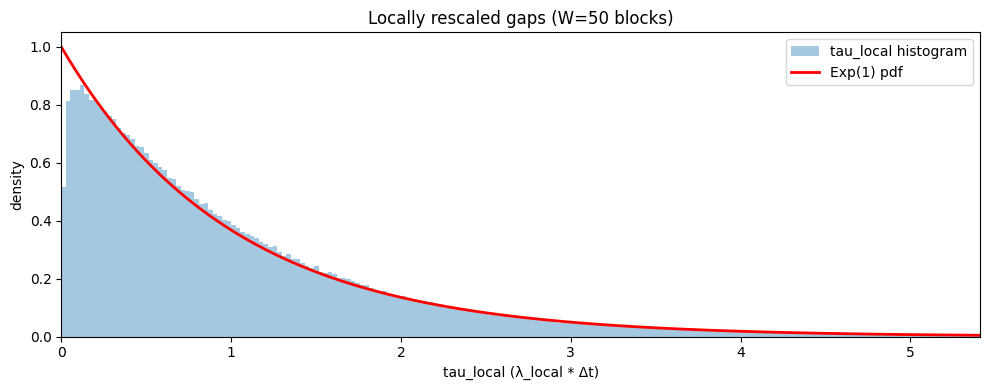

In [71]:
# ---------- 1. Extract (height, ts_s) sorted by height ----------

blk_schema  = blocks_lf.collect_schema()
blk_cols    = list(blk_schema.keys())

blk_time_col   = first_col(blk_cols, ["block_time","time","timestamp","ts","datetime"])
blk_height_col = first_col(blk_cols, ["height","block_height","number","idx","block_number"])

if blk_time_col is None or blk_height_col is None:
    raise RuntimeError("Need block height and timestamp columns.")

dt = blk_schema.get(blk_time_col)
col_ts = pl.col(blk_time_col)

# normalize timestamp to epoch seconds
if dt == pl.Datetime:
    ts_s_expr = col_ts.dt.epoch(time_unit="s").cast(pl.Int64)
elif dt in (pl.Int64, pl.Int32, pl.UInt64, pl.UInt32):
    ts_s_expr = (
        pl.when(col_ts > 100_000_000_000)
        .then((col_ts / 1000).cast(pl.Int64))
        .otherwise(col_ts.cast(pl.Int64))
    )
elif dt == pl.Date:
    raise RuntimeError("Only day-level timestamps; can't analyze seconds.")
else:
    ts_s_expr = (
        col_ts.cast(pl.Datetime, strict=False)
              .dt.epoch(time_unit="s")
              .cast(pl.Int64)
    )

# collect height + ts_s and sort
blk_ht_ts = (
    blocks_lf
    .select([
        pl.col(blk_height_col).cast(pl.Int64).alias("height"),
        ts_s_expr.alias("ts_s"),
    ])
    .sort("height")
    .collect()
)

# ---------- 2. Compute deltas Δt_i in seconds ----------
# We'll end up with arrays aligned so that:
#  delta_s[i] = ts[i] - ts[i-1], for i>=1
ts_arr      = blk_ht_ts["ts_s"].to_numpy()
height_arr  = blk_ht_ts["height"].to_numpy()

delta_s = np.diff(ts_arr).astype(np.float64)      # length N-1
height_mid = height_arr[1:]                       # align each delta with the *ending* block

# drop non-positive deltas (timestamp anomalies that go backwards or equal)
mask_pos = delta_s > 0
delta_s = delta_s[mask_pos]
height_mid = height_mid[mask_pos]

print(f"Total usable intervals: {len(delta_s)}")

# ---------- 3. Rolling local rate λ_hat over last W blocks ----------
W = 50  # ~8 hours worth of blocks if ~10 min per block

# We'll compute rolling mean of the last W deltas before each point.
# For element i, take deltas[i-W : i] (exclusive of i itself),
# then λ_i = 1 / mean(those W deltas).
#
# For the first W elements we can't compute a full window, so we'll drop them.

lam_local = np.full_like(delta_s, np.nan, dtype=np.float64)

for i in range(W, len(delta_s)):
    window = delta_s[i-W:i]
    mean_dt = window.mean()
    if mean_dt > 0:
        lam_local[i] = 1.0 / mean_dt

# now build τ_i = lam_local[i] * delta_s[i]
tau_local = lam_local * delta_s  # elementwise

# filter to the valid tail (where lam_local is defined and finite)
valid = np.isfinite(tau_local) & (tau_local > 0)
tau_local = tau_local[valid]

print(f"Rescaled (local-λ) intervals count: {len(tau_local)}")

# ---------- 4. KS test τ_local vs Exp(1) ----------
ks_stat, p_value = kstest(tau_local, expon.cdf)  # Exp(scale=1) = Exp(1)

print("KS test with rolling local λ (captures intra-epoch hashrate drift):")
print(f"  ks_stat = {ks_stat:.6f}")
print(f"  p_value = {p_value:.6g}")

if p_value < 0.05:
    print("  -> Still reject: even local hashrate volatility isn't enough.")
else:
    print("  -> Cannot reject: locally it's close to memoryless Poisson.")

# ---------- 5. Optional: inspect distribution visually ----------
# You can also sanity-check by plotting histogram of tau_local vs Exp(1)
# to see if they match ~ e^{-t}.
#

fig, ax = plt.subplots(figsize=(10,4))

# choose a sane max for visualization (e.g. 99.5% of mass)
xmax = np.percentile(tau_local, 99.5)

ax.hist(
    tau_local,
    bins=200,
    range=(0, xmax),
    density=True,
    alpha=0.4,
    edgecolor="none",
    label="tau_local histogram"
)

xs = np.linspace(0, xmax, 400)
exp1_pdf = np.exp(-xs)  # Exp(1) pdf
ax.plot(xs, exp1_pdf, color="red", linewidth=2, label="Exp(1) pdf")

ax.set_xlim(0, xmax)
ax.set_xlabel("tau_local (λ_local * Δt)")
ax.set_ylabel("density")
ax.set_title("Locally rescaled gaps (W=50 blocks)")
ax.legend()
plt.tight_layout()
plt.show()

# Empirical Structure of Bitcoin Block Arrivals

## Overview

We analyzed the time gaps between consecutive Bitcoin blocks and compared them to what theory says they *should* look like if mining were an ideal random process.

The “textbook” story is:
- Each block is found by miners hashing at some constant global rate.
- Each hash attempt is independent.
- That implies block arrivals follow a **homogeneous Poisson process** with constant rate $\lambda$, and the waiting times between blocks are i.i.d. exponential:
  
  $\Delta t_i \sim \mathrm{Exp}(\lambda), \quad \text{iid}$

  where $\mathbb{E}[\Delta t_i] = 1/\lambda$.

We tested that against real chain data, using a Kolmogorov–Smirnov (KS) goodness-of-fit test. The null hypothesis $H_0$ was:

> "The observed inter-block times are independent draws from an exponential distribution with rate $\hat{\lambda} = 1 / \overline{\Delta t}$."

**Result:**  
- KS statistic was tiny (~0.01), meaning the theoretical curve and empirical curve almost overlap visually.
- But the p-value was effectively 0 (~$10^{-42}$), so we *reject* $H_0$ with absurd confidence.

Interpretation:  
With hundreds of thousands of blocks, even tiny systematic deviations become overwhelmingly significant. So the homogeneous Poisson model is statistically falsified.

That’s the first major implication:
> Bitcoin block arrivals are **not** consistent with an i.i.d. $\mathrm{Exp}(\lambda)$ process with a single constant $\lambda$ over long history.


---

## Accounting for Slowly Varying Hashrate: Non-Homogeneous Poisson

We then gave the model more flexibility.

In reality:
- Hashrate changes over time.
- Difficulty only retargets every 2016 blocks.
- So the “effective block rate” is not constant.

A better model is a **non-homogeneous Poisson process (NHPP)** with time-varying intensity $\lambda(t)$. A standard NHPP is defined by:
- Conditional on the path $\lambda(t)$, arrivals are still Poisson-like (independent, memoryless *given* the rate),
- but $\lambda(t)$ can change in time.

Within that model, the waiting time between blocks is no longer globally $\mathrm{Exp}(\lambda)$. Instead, you define each block’s local rate $\lambda_i$ at its arrival time and test *those*.

### Piecewise-constant $\lambda$ per difficulty epoch

We approximated $\lambda(t)$ as constant inside each difficulty epoch (≈ 2016 blocks). Concretely:
1. We grouped blocks by $\mathrm{epoch\_idx} = \lfloor \text{height} / 2016 \rfloor$.
2. For each epoch, we estimated a per-epoch rate:
   $\hat{\lambda}_\text{epoch} = \frac{1}{\overline{\Delta t \text{ in epoch}}}$.
3. For each observed gap $\Delta t_i$ in that epoch, we formed the **rescaled gap**:
   $\tau_i = \hat{\lambda}_\text{epoch} \cdot \Delta t_i$.

**Theory (time-rescaling theorem):**  
If arrivals are a Poisson process with *that* epoch-wise $\hat{\lambda}_\text{epoch}$, then the $\tau_i$ should follow an $\mathrm{Exp}(1)$ distribution, i.e.

$\tau_i \sim \mathrm{Exp}(1), \quad \text{iid}.$

We then ran a KS test of $\{\tau_i\}$ against $\mathrm{Exp}(1)$.

**Result:**
- KS again strongly rejects. p-value $\sim 10^{-224}$.

Implication:
> Allowing $\lambda$ to change between epochs (every ~2 weeks) is still not enough to explain the observed structure of block arrival times.

So we falsified a second mathematical formulation:

> The “piecewise-constant-rate Poisson process with breaks at difficulty retargets” is **not** an adequate model of actual Bitcoin block timing.


---

## Modeling Intra-Epoch Hashrate Volatility

The previous model assumed the rate is constant *within* a difficulty epoch. But miners come and go even hour-to-hour:
- A mining farm turns off due to energy cost spikes.
- A large pool plugs in more ASICs.
- Grid curtailment events affect whole regions.
- Pools redistribute hashpower to different chains, or throttle.

This causes the *effective* hash rate to move within the epoch, not just between epochs.

To capture that, we built a **rolling local rate** model:
1. Sort blocks by height and compute raw inter-block times:
   $\Delta t_i = t_i - t_{i-1} \quad (> 0 \text{ seconds}).$
2. For each block $i$, estimate a *local* rate $\hat{\lambda}_i$ using the last $W$ gaps (e.g. last 50 blocks ≈ several hours):
   $\hat{\lambda}_i
   = \left(\frac{1}{W} \sum_{k=i-W}^{i-1} \Delta t_k \right)^{-1}.$  
   Intuition: “How fast were we mining *just now*, not last week?”
3. Form **locally rescaled gaps**:
   $\tau_i = \hat{\lambda}_i \cdot \Delta t_i.$

The theoretical claim here is more refined:

> If block arrivals are conditionally Poisson with *instantaneous* rate $\lambda(t)$ that changes smoothly in time, then after this local time-rescaling, the $\tau_i$ should again look like i.i.d. $\mathrm{Exp}(1)$.

This is essentially using the time-rescaling theorem for a continuously varying intensity $\lambda(t)$, approximated by a rolling estimate $\hat{\lambda}_i$.

We again tested:
$H_0: \tau_i \sim \mathrm{Exp}(1) \ \text{iid.}$

**Result:**
- The KS statistic was still ~0.02.
- The p-value was now $\sim 10^{-252}$, i.e. still effectively zero.
- We still reject $H_0$ by a ridiculous margin.

This is huge. It means:
> Even after correcting for *hour-scale* hashrate changes, the rescaled gaps do **not** behave like independent $\mathrm{Exp}(1)$ draws.

In plain English:
- It's not just “the rate drifts.”
- It's that something *else* is breaking the memoryless, independent-arrival assumption.


---

## What Is Being Violated?

Formally, a Poisson (or NHPP) model relies on two pillars:

1. **Instantaneous memorylessness:**  
   Conditional on the current intensity $\lambda(t)$, the next arrival time is exponential and independent of the past beyond $\lambda(t)$.  
   That implies:

   $\mathbb{P}(\Delta t > s + u \mid \Delta t > s, \text{history})
   = \mathbb{P}(\Delta t > u \mid \text{history})$

   after accounting for $\lambda(t)$.

2. **Independent increments:**  
   Gaps are independent given $\lambda(t)$.  
   In particular:

   $\mathrm{Cov}(\Delta t_i, \Delta t_{i+1} \mid \lambda(\cdot)) = 0.$

What we see in data suggests both pillars are bent:

### Violation A: Timestamp smoothing / manipulation
- Miners do not have to record *exact* wall-clock time in a block header.
- They are allowed some slack (must be $>$ median of last 11 blocks, must not be too far in the future).
- As a result, miners sometimes “massage” timestamps:
  - If blocks arrive too fast, timestamps can be nudged forward.
  - If there's a slow spell, timestamps can be nudged backward.
- This distorts the observed inter-block duration $\Delta t_i$, especially at the very short and very long ends.

Mathematically:
- $\Delta t_i$ is not a clean physical waiting time — it’s a **declared** waiting time.
- The mapping from physical gaps to recorded $\Delta t_i$ is not deterministic and not stationary.
- That introduces systematic bias near $\Delta t \approx 0$ and in the long tail.
- KS is incredibly sensitive with $>5\times 10^5$ samples and catches this immediately.


### Violation B: Correlated arrivals / burstiness
Mining power is *not* a swarm of millions of tiny, independent miners. In practice:
- Large pools control substantial fractions of global hashrate.
- When a high-hash pool gets “lucky,” you often see short consecutive gaps (multiple fast blocks in a row).
- Conversely, hashpower can slump (e.g. curtailment or outages), producing streaks of unusually long intervals.

This implies:
- Short gaps can cluster with short gaps.
- Long gaps can cluster with long gaps.

That is **temporal dependence**:

$\mathrm{Cov}(\Delta t_i, \Delta t_{i+1}) \neq 0.$

Even after rescaling by $\hat{\lambda}_i$, those correlations do not vanish, because $\hat{\lambda}_i$ can only “smooth” the mean rate; it does not erase the *burst structure* or miner coordination.

This breaks the NHPP assumption that, conditional on $\lambda(t)$, arrivals are independent.

In other words: we’re observing something closer to a **Cox process / cluster process** than a simple NHPP. The effective rate is driven by latent regimes (pool behavior, energy shocks, timestamp politics), not just smooth drift. This is stronger than “non-homogeneous Poisson;” it’s “non-homogeneous and not independent.”


---

## Implications

1. **Global homogeneous Poisson is falsified.**  
   The fit $\Delta t_i \sim \mathrm{Exp}(\lambda)$ with constant $\lambda$ is statistically rejected. Hashrate changes over time make that model unrealistic at chain scale.

2. **Piecewise-constant Poisson by difficulty epoch is falsified.**  
   Modeling each 2016-block epoch with its own $\lambda$ still fails. We reject the hypothesis that:

   $\Delta t_i \mid \text{epoch} \sim \mathrm{Exp}(\lambda_\text{epoch}) \ \text{iid.}$

   Interpretation: hashrate and behavior change *inside* an epoch, not just at retarget boundaries.

3. **Locally adjusted Poisson with rolling $\lambda$ is also falsified.**  
   Even after giving each block its own local estimated rate $\hat{\lambda}_i$ based on the last ~50 blocks (hours-scale behavior), and rescaling:

   $\tau_i = \hat{\lambda}_i \cdot \Delta t_i,$

   the $\tau_i$ do not look i.i.d. $\mathrm{Exp}(1)$. The KS test destroys that null with p-values on the order of $10^{-200}$ or smaller.

   So we’re beyond “non-stationary intensity.” We’re seeing genuine dependence and shaping.

4. **What this means physically:**
   - Miners act in coordinated pools that exhibit burstiness (temporal clustering).
   - Timestamp declarations introduce structured distortion in the observed $\Delta t$ distribution.
   - Hashrate can shift quickly due to operational factors (energy cost spikes, maintenance, curtailment), creating multi-timescale variation not captured by one rolling window.
   - There are multi-regime “states” of the network that persist longer than a single block but shorter than a difficulty epoch.

   Mathematically, this starts to look more like:
   - a **Cox process** (doubly stochastic Poisson) where $\lambda(t)$ itself is random and can jump,
   - plus **temporal correlation** between arrivals, which violates the independent-increments assumption even conditional on $\lambda(t)$.

   In that world, arrivals are not just “Poisson with a fancy $\lambda(t)$” — they're structured by miner economics, coordination, and protocol leeway.

5. **Bottom line:**
   Bitcoin blocks are *approximately* memoryless only at a cartoonish level (what you see on a log-scale histogram looks exponential-ish around 10 minutes).  
   But statistically, at resolution of hundreds of thousands of blocks, the process:
   - is non-stationary,
   - is regime-switching,
   - shows temporal dependence,
   - and uses timestamps that do not purely encode physical time.

   The classical assumption

   $\{\Delta t_i\} \ \text{are iid } \mathrm{Exp}(\lambda)$

   — and even the refined assumption

   $\Delta t_i \mid \lambda(t_i) \ \sim \mathrm{Exp}(\lambda(t_i)) \ \text{iid}$

   — is violated.

   What we really have is closer to:

   $\Delta t_i \sim \mathrm{Exp}(\Lambda_i), \quad
   \Lambda_i \text{ is itself a random, regime-driven process with memory,}$

   plus post-hoc timestamp smoothing that injects additional bias.

   That is not a standard NHPP anymore; it's effectively a **clustered, regime-switching Cox process with noisy time stamps.**


---

## Practical Consequences

- If you simulate Bitcoin blocks assuming $\mathrm{Poisson}(\lambda = 1/600\text{ s}^{-1})$, you're missing:
  - burst clusters of super-fast blocks,
  - multi-hour droughts that occur more often than Poisson predicts,
  - timestamp manipulations,
  - weekday / diurnal / geopolitical energy effects.

- If you’re trying to estimate miner behavior, security, or congestion based on a naive exponential model of inter-block time, that model is provably too simple.

- A better generative model for Bitcoin blocks is:
  1. A latent mining regime (describing effective hashrate, connectivity, and strategic behavior),
  2. A fast-timescale Poisson-like process *within that regime*,
  3. Occasional regime switches,
  4. Plus timestamp post-processing.

In other words:  
**The data implies that Bitcoin block production is not just random hashing. It’s economic, social, and strategic — and the math can see it.**


## 4) Fees per day (BTC) & 7d MA

Logic:
For each block height in a given day:
1) Sum outputs per tx -> out_sats
2) Compute subsidy_sats(height)
3) delta_sats = out_sats - subsidy_sats
4) Keep only rows where delta_sats >= 0
5) fee_sats(block) = MIN(delta_sats) within that block (closest-above-subsidy tx)
   Then:
     - cap absurd per-block fees (data artifact in 2009-2010)
     - sum fee_sats(block) across all blocks in the day
     - convert sats -> BTC

 Why this works:
   - We don't need inputs (vin values are missing in your dump anyway)
   - We don't rely on vin_count / coinbase heuristics
   - We avoid mistaking giant whale payouts for miner fees
   - We stream day by day so memory doesn't explode

Detected SAT_PER_VALUE = 100000000.0
Fees daily (tail):
shape: (5, 3)
┌────────────┬───────────┬──────────────┐
│ day        ┆ fees_btc  ┆ fees_btc_ma7 │
│ ---        ┆ ---       ┆ ---          │
│ date       ┆ f64       ┆ f64          │
╞════════════╪═══════════╪══════════════╡
│ 2018-07-08 ┆ 12.832792 ┆ 13.39616     │
│ 2018-07-09 ┆ 12.767493 ┆ 12.860979    │
│ 2018-07-10 ┆ 13.520961 ┆ 12.815726    │
│ 2018-07-11 ┆ 11.659198 ┆ 12.566774    │
│ 2018-07-12 ┆ 9.475859  ┆ 12.141258    │
└────────────┴───────────┴──────────────┘
   min_fees_btc  median_fees_btc  max_fees_btc
0      0.007654        13.789694    100.561278


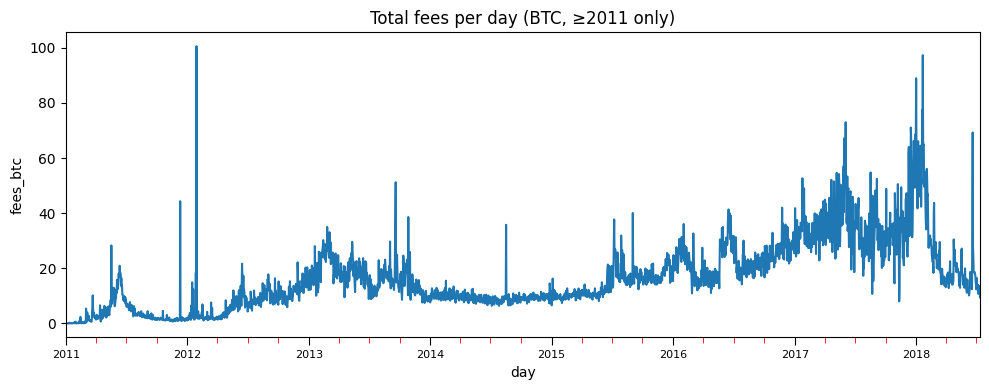

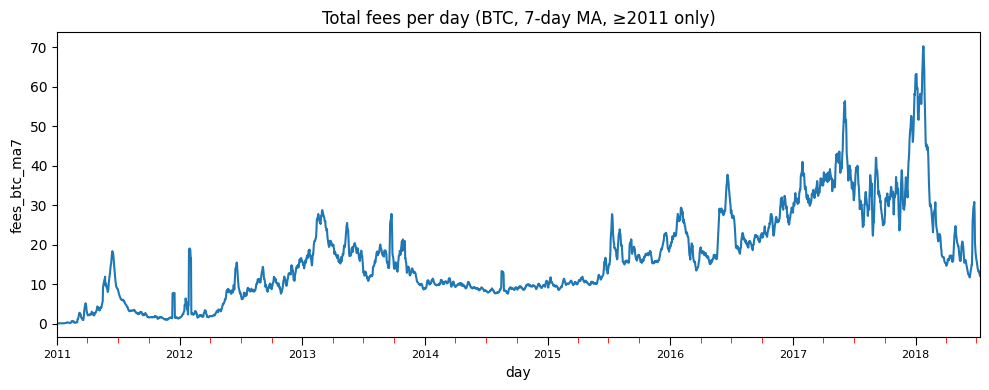

In [72]:
# ---------------------------------
# 1. Subsidy helper
# ---------------------------------
def block_subsidy_sats(height: int) -> int:
    halvings = height // 210_000
    base = 50 * 100_000_000  # 50 BTC in sats
    sub = base >> halvings   # halve each halving via right shift
    return max(sub, 0)

# ---------------------------------
# 2. Detect units in io_lf["value"]
#    (BTC vs sats)
# ---------------------------------
val_stats = (
    io_lf
    .select(pl.col("value").max().alias("mx"))
    .collect(engine="streaming")
)
mx = float(val_stats["mx"][0])

# Heuristic:
#   - if max(value) <= ~1e6 → column is probably BTC (like 12.3, 25.7, ...)
#     so multiply by 1e8 to get sats
#   - else assume it's already sats
SAT_PER_VALUE = 1e8 if mx <= 1e6 else 1.0
print(f"Detected SAT_PER_VALUE = {SAT_PER_VALUE}")

# ---------------------------------
# 3. Get all unique days (partition key)
# ---------------------------------
all_days = (
    io_lf
    .select(pl.col("day").unique())
    .collect(engine="streaming")
    .sort("day")["day"]
    .to_list()
)

# sanity cap per *block* fee
cap_btc_per_block  = 100.0
cap_sats_per_block = int(cap_btc_per_block * 1e8)

daily_rows = []

# ---------------------------------
# 4. Loop over days, infer fees
# ---------------------------------
for d in all_days:
    # 4a. aggregate outputs per (height, txid) in sats
    out_sums = (
        io_lf
        .filter(pl.col("day") == pl.lit(d))
        .select([
            "height",
            "txid",
            (pl.col("value") * SAT_PER_VALUE)
                .round(0)
                .cast(pl.Int64)
                .alias("value_sats"),
        ])
        .group_by(["height", "txid"])
        .agg(
            pl.col("value_sats").sum().alias("out_sats")
        )
        .collect(engine="streaming")
    )

    if out_sums.height == 0:
        daily_rows.append({"day": d, "fees_btc": 0.0})
        continue

    # 4b. subsidy and delta
    with_subsidy = (
        out_sums
        .with_columns(
            pl.col("height")
            .map_elements(block_subsidy_sats, return_dtype=pl.Int64)
            .alias("subsidy_sats")
        )
        .with_columns(
            (pl.col("out_sats") - pl.col("subsidy_sats")).alias("delta_sats")
        )
    )

    # 4c. keep only nonnegative deltas
    nonnegative = with_subsidy.filter(pl.col("delta_sats") >= 0)

    if nonnegative.height == 0:
        daily_rows.append({"day": d, "fees_btc": 0.0})
        continue

    # 4d. infer per-block fees:
    #      pick MIN nonneg delta per block (height),
    #      then cap at 100 BTC/block to kill insane early artifacts
    fees_per_block = (
        nonnegative
        .group_by("height")
        .agg(
            pl.col("delta_sats").min().alias("fee_sats_block")
        )
        .with_columns(
            pl.when(pl.col("fee_sats_block") > cap_sats_per_block)
            .then(cap_sats_per_block)
            .otherwise(pl.col("fee_sats_block"))
            .alias("fee_sats_block_capped")
        )
    )

    # 4e. per-day total fee in BTC
    day_fee_sats = int(fees_per_block["fee_sats_block_capped"].sum())
    day_fee_btc  = day_fee_sats / 1e8

    daily_rows.append({
        "day": d,
        "fees_btc": day_fee_btc,
    })

# ---------------------------------
# 5. Build daily DataFrame
# ---------------------------------
fees_daily_all = (
    pl.DataFrame(daily_rows)
    .with_columns(pl.col("day").cast(pl.Date))
    .sort("day")
)

# ---------------------------------
# 6. FILTER OUT ANCIENT ERA
#    Keep only rows where day >= 2011-01-01.
#    This is the key new step.
# ---------------------------------

cutoff_date = pl.date(2011, 1, 1)

fees_daily = (
    fees_daily_all
    .filter(pl.col("day") >= cutoff_date)
    .with_columns(
        pl.col("fees_btc")
        .rolling_mean(window_size=7)
        .alias("fees_btc_ma7")
    )
)

# ---------------------------------
# 7. Inspect summary stats on filtered data only
# ---------------------------------
print("Fees daily (tail):")
print(fees_daily.tail(5))

print(
    fees_daily.select([
        pl.col("fees_btc").min().alias("min_fees_btc"),
        pl.col("fees_btc").median().alias("median_fees_btc"),
        pl.col("fees_btc").max().alias("max_fees_btc"),
    ]).to_pandas()
)

# ---------------------------------
# 8. Plot (filtered data)
# ---------------------------------
lineplot(
    fees_daily,
    "day",
    "fees_btc",
    "Total fees per day (BTC, ≥2011 only)",
    logy=False,
)

lineplot(
    fees_daily,
    "day",
    "fees_btc_ma7",
    "Total fees per day (BTC, 7-day MA, ≥2011 only)",
    logy=False,
)


Fee rate (sat/vB) for recent activity (360d window, KDE overlay) \
We estimate per-block avg fee rate over the last ~360 days: \
   fee_rate_block = (block_fee_sats / block_vbytes)  [sat/vB] \
Then we:
- take log10(fee_rate_block)
- plot a histogram of those values
- overlay a kernel density curve in orange

[fee_rate] SAT_PER_VALUE = 100000000.0


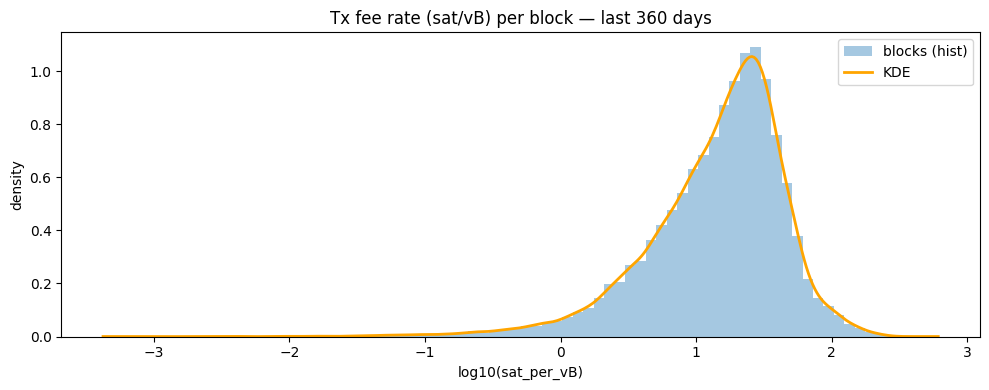

In [73]:
# --- helper: block subsidy in sats ---
def block_subsidy_sats(height: int) -> int:
    halvings = height // 210_000
    base = 50 * 100_000_000  # 50 BTC in sats
    sub = base >> halvings
    return max(sub, 0)

# --- detect sats/BTC units in io_lf.value ---
val_stats = (
    io_lf
    .select(pl.col("value").max().alias("mx"))
    .collect(engine="streaming")
)
mx = float(val_stats["mx"][0])
SAT_PER_VALUE = 1e8 if mx <= 1e6 else 1.0
print(f"[fee_rate] SAT_PER_VALUE = {SAT_PER_VALUE}")

# --- 1. latest day in txs_lf ---
max_day_df = (
    txs_lf
    .select(pl.col("day").max().alias("max_day"))
    .collect(engine="streaming")
)
max_day = max_day_df["max_day"][0]

# --- 2. cutoff = last 180 days ---
cutoff_day = max_day - datetime.timedelta(days=180)

# --- 3. restrict to recent window ---
tx_recent_lf = txs_lf.filter(pl.col("day") >= pl.lit(cutoff_day))
io_recent_lf = io_lf.filter(pl.col("day") >= pl.lit(cutoff_day))

# --- 4. per-(height, txid) total outputs in sats (recent window only) ---
out_sums_recent = (
    io_recent_lf
    .select([
        "height",
        "txid",
        (pl.col("value") * SAT_PER_VALUE)
            .round(0)
            .cast(pl.Int64)
            .alias("value_sats"),
    ])
    .group_by(["height", "txid"])
    .agg(
        pl.col("value_sats").sum().alias("out_sats")
    )
    .collect(engine="streaming")
)

# --- 5. attach subsidy + compute delta per tx in that block ---
with_subsidy_recent = (
    out_sums_recent
    .with_columns(
        pl.col("height").map_elements(
            block_subsidy_sats,
            return_dtype=pl.Int64
        ).alias("subsidy_sats")
    )
    .with_columns(
        (pl.col("out_sats") - pl.col("subsidy_sats")).alias("delta_sats")
    )
)

# keep only txs where outputs >= subsidy (delta >= 0)
nonnegative_recent = with_subsidy_recent.filter(pl.col("delta_sats") >= 0)

# --- 6. per-block fee_sats = MIN nonnegative delta in that block ---
fees_per_block_recent = (
    nonnegative_recent
    .group_by("height")
    .agg(
        pl.col("delta_sats").min().alias("fee_sats_block")
    )
)

# --- 7. per-block total vbytes (sum tx vsize or weight/4) ---
tx_schema_names = txs_lf.collect_schema().names()
have_vsize  = "vsize"  in tx_schema_names
have_weight = "weight" in tx_schema_names

needed_cols = ["height"]
if have_vsize:
    needed_cols.append("vsize")
if have_weight:
    needed_cols.append("weight")

block_sizes_recent = (
    tx_recent_lf
    .select(needed_cols)
    .collect(engine="streaming")
)

# compute per-tx virtual bytes
if have_vsize:
    block_sizes_recent = block_sizes_recent.with_columns(
        pl.col("vsize").cast(pl.Float32).alias("vbytes_tx")
    )
elif have_weight:
    block_sizes_recent = block_sizes_recent.with_columns(
        (pl.col("weight") / 4).cast(pl.Float32).alias("vbytes_tx")
    )
else:
    raise RuntimeError("No vsize/weight columns available; can't estimate vbytes.")

# sum vbytes per block height
vbytes_per_block_recent = (
    block_sizes_recent
    .group_by("height")
    .agg(
        pl.col("vbytes_tx").sum().alias("block_vbytes")
    )
)

# --- 8. join fees + block size, get block avg fee rate in sat/vB ---
block_fee_rates = (
    fees_per_block_recent
    .join(vbytes_per_block_recent, on="height", how="inner")
    .with_columns(
        (pl.col("fee_sats_block").cast(pl.Float32) /
         pl.col("block_vbytes").cast(pl.Float32))
        .alias("sat_per_vb_block")
    )
    .filter(
        pl.col("sat_per_vb_block").is_finite()
        & (pl.col("sat_per_vb_block") > 0)
        & (pl.col("sat_per_vb_block") < 5000)
    )
    .select("sat_per_vb_block")
)

fee_rate_series = (
    block_fee_rates
    .get_column("sat_per_vb_block")
    .cast(pl.Float32)
)

# --- 9. Plot histogram of log10(fee rate) + KDE overlay in orange ---
def plot_fee_rate_distribution(fee_rate_series: pl.Series):
    x_raw = fee_rate_series.drop_nulls().to_numpy()

    if x_raw.size == 0:
        print("No data to plot for fee rate distribution (360d).")
        return

    # x_log is log10(sat_per_vb_block)
    x_log = np.log10(x_raw[x_raw > 0])

    if x_log.size == 0:
        print("No strictly positive fee rates to plot.")
        return

    fig, ax = plt.subplots(figsize=(10,4))

    # histogram (density normalized so KDE is on same scale)
    ax.hist(
        x_log,
        bins=80,
        density=True,
        alpha=0.4,
        edgecolor="none",
        label="blocks (hist)"
    )

    kde = gaussian_kde(x_log)
    xs  = np.linspace(x_log.min(), x_log.max(), 400)
    ys  = kde(xs)
    ax.plot(xs, ys, color="orange", linewidth=2.0, label="KDE")

    ax.set_title("Tx fee rate (sat/vB) per block — last 360 days")
    ax.set_xlabel("log10(sat_per_vB)")
    ax.set_ylabel("density")
    ax.legend()
    fig.tight_layout()
    plt.show()

plot_fee_rate_distribution(fee_rate_series)

## 5) Day-of-week pattern in tx count

Avg tx per weekday:
shape: (7, 3)
┌─────────────┬──────────────┬──────────────┐
│ weekday_num ┆ avg_tx       ┆ weekday_name │
│ ---         ┆ ---          ┆ ---          │
│ i8          ┆ f64          ┆ str          │
╞═════════════╪══════════════╪══════════════╡
│ 1           ┆ 95386.006048 ┆ Mon          │
│ 2           ┆ 99916.97379  ┆ Tue          │
│ 3           ┆ 99775.893145 ┆ Wed          │
│ 4           ┆ 99039.207661 ┆ Thu          │
│ 5           ┆ 96672.22379  ┆ Fri          │
│ 6           ┆ 87448.806841 ┆ Sat          │
│ 7           ┆ 82259.552419 ┆ Sun          │
└─────────────┴──────────────┴──────────────┘


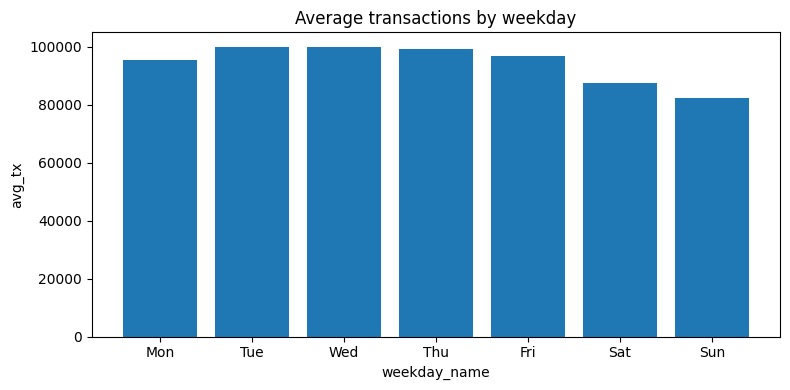

In [74]:
# We assume you already have `daily_tx`, which looks like:
#   day          tx_count   tx_count_ma7
#   <str|date>   <u32>      <f64>
#
# Goal: average tx_count by weekday (Mon..Sun)

# 1. Normalize "day" into a real Date column expression
day_dtype = daily_tx.schema["day"]

if day_dtype == pl.Utf8:
    # parse "YYYY-MM-DD" style strings into Date
    day_parsed_expr = pl.col("day").str.strptime(pl.Date, strict=False)
elif day_dtype == pl.Date:
    # already Date
    day_parsed_expr = pl.col("day")
elif day_dtype == pl.Datetime:
    # drop time -> just date
    day_parsed_expr = pl.col("day").dt.date()
else:
    # best effort fallback
    day_parsed_expr = pl.col("day").cast(pl.Date)

# 2. Compute weekday averages
# Polars .dt.weekday() here returns 1..7 (Mon=1, Sun=7)
dow = (
    daily_tx
    .with_columns(
        day_parsed_expr.alias("day_parsed")
    )
    .with_columns(
        pl.col("day_parsed").dt.weekday().alias("weekday_num")  # 1=Mon ... 7=Sun
    )
    .group_by("weekday_num")
    .agg(
        pl.col("tx_count").mean().alias("avg_tx")
    )
    .sort("weekday_num")
    .with_columns(
        # Map 1..7 to weekday names using safe indexing (i-1)
        pl.col("weekday_num").map_elements(
            lambda i: ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"][int(i) - 1],
            return_dtype=pl.Utf8,
        ).alias("weekday_name")
    )
)

print("Avg tx per weekday:")
print(dow)

# 3. Plot using your existing helper (converts to pandas internally)
barplot(
    dow,
    x="weekday_name",
    y="avg_tx",
    title="Average transactions by weekday"
)


# If to initiate the node extra data can be obtained

In [75]:
# -------------------------------------------------
# RPC config / toggle
# -------------------------------------------------
USE_RPC   = False  # <- flip to True if you actually want live node data
RPC_URL   = "http://127.0.0.1:8332"
RPC_USER  = "research"
RPC_PASS  = "researchpass"

def _cid():
    """
    Best-effort helper to find the docker container ID for bitcoind.
    Only used if USE_RPC is True and direct HTTP RPC fails.
    """
    try:
        return subprocess.check_output(
            [
                "bash", "-lc",
                "docker compose -f ~/btc-node/docker-compose.yml ps -q bitcoind"
            ],
            text=True
        ).strip()
    except Exception:
        return ""

def rpc(method, params=None, timeout=10, required=False):
    """
    Light wrapper around Bitcoin Core RPC.
    If USE_RPC == False, this immediately returns None.
    If USE_RPC == True, we try:
      1. direct HTTP RPC to bitcoind
      2. fallback to `docker exec bitcoin-cli` if available
    Behavior:
      - If required=False and we fail, return None.
      - If required=True and we fail, raise.
    """
    if not USE_RPC:
        # offline mode by design
        if required:
            raise RuntimeError(f"RPC call `{method}` requested but USE_RPC=False")
        return None

    import requests  # import only if needed

    try:
        r = requests.post(
            RPC_URL,
            json={
                "jsonrpc": "1.0",
                "id":      "nb",
                "method":  method,
                "params":  params or []
            },
            auth=(RPC_USER, RPC_PASS),
            timeout=timeout,
        )

        # Special-case: node warming up -> Core returns code -28
        if r.status_code == 500:
            j = r.json()
            if j.get("error", {}).get("code") == -28 and not required:
                return None

        r.raise_for_status()
        j = r.json()

        if j.get("error"):
            if required:
                raise RuntimeError(j["error"])
            return None

        return j["result"]

    except Exception:
        # Fallback path: try docker exec + bitcoin-cli
        try:
            cid = _cid()
            if not cid:
                if required:
                    raise ConnectionError("RPC down and container not found")
                return None

            cmd = [
                "docker", "exec", "-i", cid, "bitcoin-cli",
                f"-rpcuser={RPC_USER}",
                f"-rpcpassword={RPC_PASS}",
                method,
            ]

            for p in (params or []):
                cmd.append(
                    json.dumps(p) if isinstance(p, (dict, list)) else str(p)
                )

            out = subprocess.check_output(cmd, text=True).strip()

            # bitcoin-cli might print raw json or just a scalar
            try:
                return json.loads(out)
            except Exception:
                return out

        except Exception:
            if required:
                raise
            return None

def node_tip_or_none():
    """
    Return current chain tip height if RPC is live.
    Otherwise return None.
    """
    res = rpc("getblockcount")
    return int(res) if isinstance(res, int) else None

tip = node_tip_or_none()
if tip is None:
    print("RPC disabled or node not reachable; running purely from Parquet.")
else:
    print(f"Node height: {tip}")

RPC disabled or node not reachable; running purely from Parquet.


In [76]:
SAT = 100_000_000

# ---------------------------
# Helpers
# ---------------------------
def script_type_expr(addr_col: str = "addr_norm") -> pl.Expr:
    a = pl.col(addr_col).cast(pl.Utf8, strict=False)
    return (
        pl.when(a.is_null() | (a == ""))
          .then(pl.lit(None, dtype=pl.Utf8))
        .when(a.str.starts_with(("bc1p","tb1p"))).then(pl.lit("p2tr"))        # Taproot
        .when(a.str.startswith(("bc1q","tb1q"))).then(pl.lit("v0_segwit"))    # SegWit v0
        .when(a.str.startswith(("1","m","n"))).then(pl.lit("p2pkh"))          # legacy
        .when(a.str.startswith(("3","2"))).then(pl.lit("p2sh"))               # legacy SH
        .otherwise(pl.lit("other"))
    )

def enrich_day(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns([
        pl.col("time").dt.date().alias("day"),
        pl.col("time").dt.year().alias("year"),
        pl.col("time").dt.month().alias("month"),
    ])

In [77]:
# ---------------------------
# Stable path: daily outputs
# ---------------------------
io_schema = io_lf.collect_schema()
# Detect units for 'value'
mx = float(io_lf.select(pl.max("value").alias("mx")).collect(engine="streaming")["mx"][0])
# <=1e6 ⇒ BTC, else already sats-like
value_btc_expr = pl.col("value").cast(pl.Float64, strict=False) if mx <= 1e6 else (
    pl.col("value").cast(pl.Float64, strict=False) / SAT
)

# Keep only outputs, compute value_btc/value_sat
need_cols = ["dir","value","time"] + (["address"] if "address" in io_schema else [])
io_out_base = (
    io_lf
    .select(need_cols)
    .filter(
        pl.col("dir").cast(pl.Utf8, strict=False).str.to_lowercase().str.contains("out", literal=True)
        & pl.col("value").is_not_null()
    )
    .with_columns([
        value_btc_expr.alias("value_btc"),
        (value_btc_expr * SAT).round(0).cast(pl.Int64, strict=False).alias("value_sat"),
    ])
)

In [78]:
# Daily totals (robust; no address)
io_out_day_lf = enrich_day(io_out_base)
out_value_daily = (
    io_out_day_lf
    .group_by("day")
    .agg([
        pl.sum("value_btc").alias("total_btc"),
        pl.sum("value_sat").alias("total_sat"),
        pl.count().alias("n_outs"),
    ])
    .sort("day")
    .collect(engine="streaming")
)

/tmp/ipykernel_27929/4203580067.py:9: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("n_outs"),


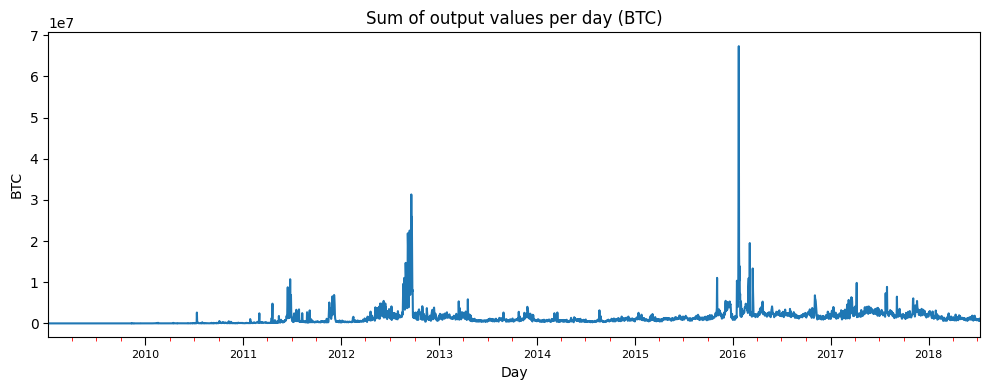

In [79]:
# Plot daily BTC outputs
pdf = out_value_daily.to_pandas()
pdf["day"] = pd.to_datetime(pdf["day"], errors="coerce")
pdf = pdf.dropna(subset=["day"])

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(pdf["day"], pdf["total_btc"])
ax.set_title("Sum of output values per day (BTC)")
ax.set_xlabel("Day"); ax.set_ylabel("BTC")
ax.xaxis.set_major_locator(mdates.YearLocator(base=1, month=1, day=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1,4,7,10], bymonthday=1))
ax.tick_params(axis='x', which='major', labelrotation=0, labelsize=8, length=6)
ax.tick_params(axis='x', which='minor', length=3, colors='red', labelbottom=False)
ax.set_xlim(pdf["day"].min(), pdf["day"].max())
fig.tight_layout(); plt.show()

In [80]:
# ============================
# OPTIONAL (robust address path)
# ============================
# Some partitions store `address` as Null/List/Utf8. To analyze addresses:
#  1) re-scan the same Parquets with a dtype override for `address` -> Utf8
#  2) optionally limit to a modern window where the schema is consistent
#
# If PARQUET_DIR is available, use it; otherwise adjust the glob below.

try:
    # Adjust this glob if your path differs
    io_glob = str(PARQUET_DIR / "io/day=*/io-*.parquet")  # e.g. "/path/to/io/day=*/io-*.parquet"
    io_addr_lf = pl.scan_parquet(io_glob, dtypes={"address": pl.Utf8})

    # Limit to a safer era (post-2011) to avoid early oddballs
    SAFER_START = datetime(2011, 1, 1)

    io_addr_out = (
        io_addr_lf
        .select(["dir","value","time","address"])
        .filter(
            pl.col("dir").cast(pl.Utf8, strict=False).str.to_lowercase().str.contains("out", literal=True)
            & pl.col("value").is_not_null()
            & (pl.col("time") >= pl.lit(SAFER_START))
        )
        .with_columns([
            # value normalization again (mirror above)
            (pl.col("value").cast(pl.Float64, strict=False) if mx <= 1e6 else
             (pl.col("value").cast(pl.Float64, strict=False) / SAT)
            ).alias("value_btc"),
            pl.col("time").dt.date().alias("day"),
            pl.col("address").alias("addr_norm"),
        ])
    )

    # --- Top addresses (counts) ---
    top_addrs = (
        io_addr_out
        .filter(pl.col("addr_norm").is_not_null() & (pl.col("addr_norm") != ""))
        .group_by("addr_norm")
        .len()
        .sort("len", descending=True)
        .limit(25)
        .collect(engine="streaming")
    )
    display(top_addrs)

    # --- Script-type breakdown ---
    io_addr_typed = io_addr_out.with_columns(
        script_type_expr("addr_norm").alias("script_type")
    )

    by_type = (
        io_addr_typed
        .group_by(["day","script_type"])
        .agg(pl.sum("value_btc").alias("btc"))
        .sort(["day","script_type"])
        .collect(engine="streaming")
    )

    pvt = by_type.pivot(values="btc", index="day", on="script_type").sort("day")
    pdf2 = pvt.to_pandas()
    pdf2["day"] = pd.to_datetime(pdf2["day"], errors="coerce")
    pdf2 = pdf2.dropna(subset=["day"]).set_index("day").fillna(0.0)

    if len(pdf2.columns):
        fig, ax = plt.subplots(figsize=(10,4))
        ax.stackplot(pdf2.index, *[pdf2[c].values for c in pdf2.columns], labels=list(pdf2.columns))
        ax.set_title("Daily BTC outputs by script type")
        ax.set_xlabel("Day"); ax.set_ylabel("BTC")
        ax.legend(loc="upper left", ncol=3, fontsize=8)
        ax.xaxis.set_major_locator(mdates.YearLocator(base=1, month=1, day=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1,4,7,10], bymonthday=1))
        ax.tick_params(axis='x', which='major', labelrotation=0, labelsize=8, length=6)
        ax.tick_params(axis='x', which='minor', length=3, colors='red', labelbottom=False)
        fig.tight_layout(); plt.show()
    else:
        print("No script_type categories present.")

except Exception as e:
    # If anything about address still explodes, keep the core plots and move on.
    print("Address analysis skipped (mixed Parquet schemas). Details:", type(e).__name__, str(e))


Address analysis skipped (mixed Parquet schemas). Details: TypeError scan_parquet() got an unexpected keyword argument 'dtypes'
